# Open system dynamics

See that the qubitdyne protocol emulates open system dynamics, and that simulated additional cavity loss is correctly implemented.

In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
from tqdm import tqdm
from qutip import *
from scipy.interpolate import interp1d
from scipy.special import factorial, eval_hermite, comb
from scipy.integrate import quad
from joblib import Parallel, delayed

## Define basic operators

In [2]:
N=5

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

N_cav = tensor(num(N), ida)

## Define unitaries

In [3]:
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def H_int(g, dt):
    Hint = (-1j) * g*np.sqrt(dt) * (a.dag() * sm + a * sm.dag())
    return Hint.expm()

def U_gint(gint):
    H = (-1j) * gint * (a.dag() * sm + a * sm.dag())
    return H.expm()

## Parameters and initial state

(0.31622776601683794, 4, 0.05)

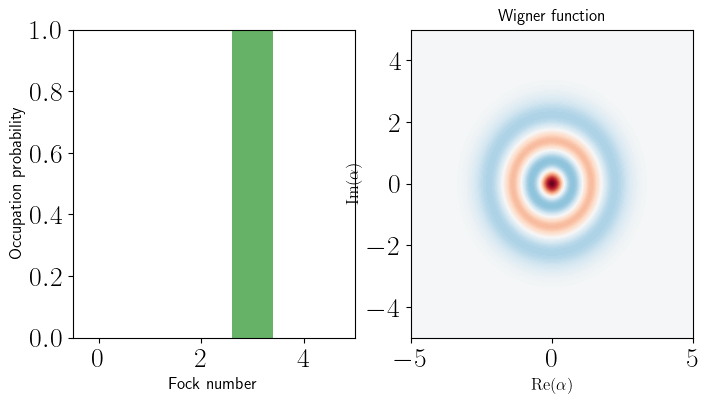

In [4]:
# number of qubit measurements per trajectory
Nmeas = 80

# number of trajectories
Ntrajs = 100

# interaction strength
g = 2 # MHz

delta_t = 0.025 #µs

gamma = g**2

# effective interaction strength
gint = np.sqrt(gamma*delta_t)

# initialize state

initial_cavity = fock(N,3)
psi0 = tensor(initial_cavity, basis(2,0))
n_init = expect(N_cav, psi0)
plot_wigner_fock_distribution(initial_cavity, alpha_max=5)

gint, gamma, gint*np.sqrt(delta_t)

## Mode matching function

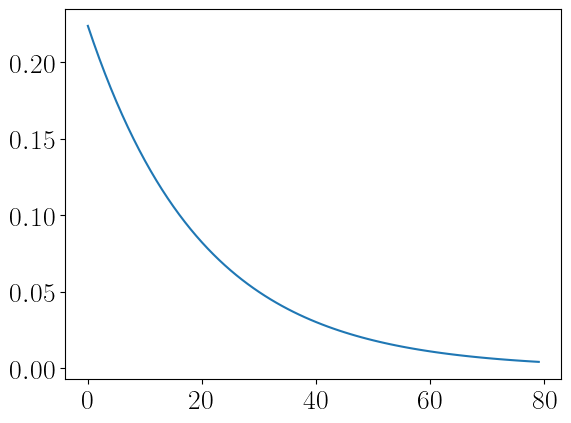

In [5]:
# weight measurement results with exponential filter
nsteps = np.arange(Nmeas)

nsteps = np.linspace(0,Nmeas-1,Nmeas)
weights=(gint/np.sqrt(2))*np.exp(-nsteps*(gint**2/2))
plt.plot(weights)

# Observe open system dynamics of cavity
No additional loss, effective decay rate $\gamma$.

In [6]:
U_int = H_int(g, delta_t)

prng = np.random.RandomState(187890)

qbrotmat = rotateXY(np.pi/2,0) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state


n_cav_avg = np.zeros(Nmeas)
measurements = []
for j in tqdm(range(Ntrajs)):
        xrnd = prng.rand(Nmeas)
    
        results = []
        psi = ket2dm(psi0)
        n_cav = []
        
        for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
            U = qbrotmat * U_int 
            #U = U_int
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)
                       
            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
     
        measurement = np.sum(results*weights)
        measurements.append(measurement)
        n_cav_avg += n_cav

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.68it/s]


In [7]:
# solve master equation (ME) to compare with
tlist = nsteps*delta_t

c_op=[np.sqrt(gamma)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist, c_ops=c_op, e_ops=[N_cav])

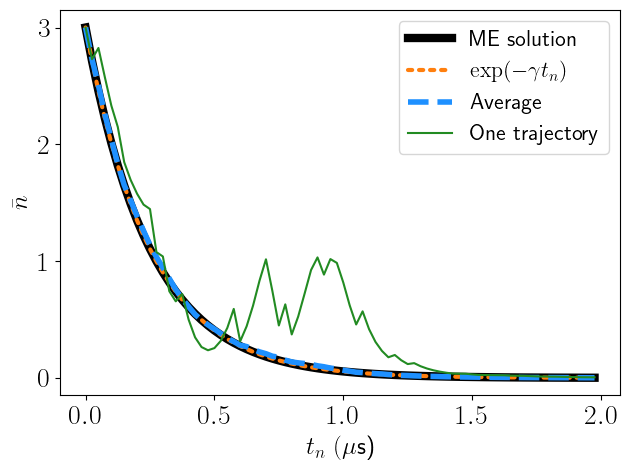

In [8]:
plt.plot(tlist, sol.expect[0],'k',linewidth=6, label='ME solution')
plt.plot(tlist, n_init*np.exp(-gamma*tlist),'C1',linestyle=':', dash_capstyle = 'round', linewidth=3, label='$\exp(-\gamma t_n)$')
plt.plot(tlist, n_cav_avg/Ntrajs,'dodgerblue', linestyle='--', linewidth=4, label='Average')
plt.plot(tlist, n_cav, 'forestgreen', label='One trajectory')

plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')

plt.legend()
plt.tight_layout()

# Only loss

Note the longer timescale: consider 500 ns for one whole step (interact, measure and reset).

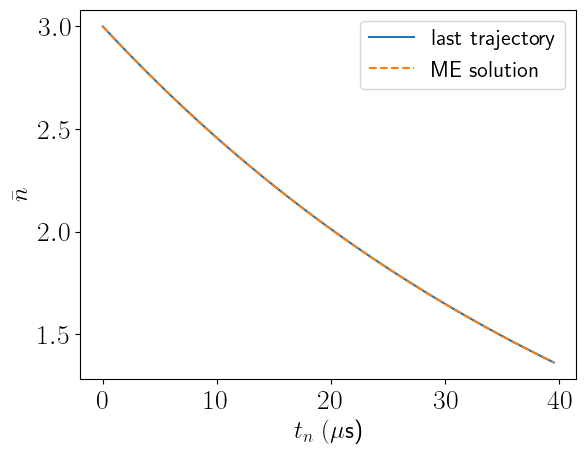

In [9]:
n_cav = []
psi = ket2dm(psi0) 

# CAVITY LOSS RATE
# T1 = 50 µs => kappa = 1/T1 = 1/50 = 0.02
kappa = 0.02

dt_total = 0.5 # consider 500 ns for one whole step (interact, measure, reset).

tlist_total = nsteps*dt_total

L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
op = L.expm()

for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
                       
            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)
            
c_op=[np.sqrt(kappa)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist_total, c_ops=c_op, e_ops=[N_cav])            
       
plt.plot(tlist_total, n_cav, label='last trajectory')    
plt.plot(tlist_total, sol.expect[0], '--',label='ME solution')            

plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')
plt.legend();

# Additional cavity decay
with rate $\kappa$. Neglecting total time, only considering interaction time $\Delta t$.

In [10]:
# cavity decay rate
kappa = 0.3

L = liouvillian(0*a, [np.sqrt(kappa*delta_t)*a])
op = L.expm()

n_cav_avg = np.zeros(Nmeas)
measurements = []
for j in tqdm(range(Ntrajs)):
        xrnd = prng.rand(Nmeas)
    
        results = []
        psi = ket2dm(psi0)
        n_cav = []
        
        for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
            U = qbrotmat * U_int 
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)
                       
            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
     
        measurement = np.sum(results*weights)
        measurements.append(measurement)
        n_cav_avg += n_cav

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.24it/s]


In [11]:
tlist = nsteps*delta_t

gamma_effective = gamma + kappa

c_op=[np.sqrt(gamma_effective)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist, c_ops=c_op, e_ops=[N_cav])
             

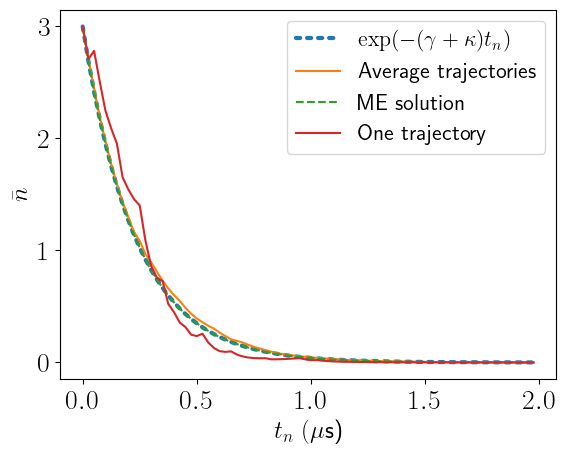

In [12]:
plt.plot(tlist, n_init*np.exp(-(gamma + kappa)*tlist),linestyle=':', dash_capstyle = 'round', linewidth=3, label='$\exp(-(\gamma +\kappa)t_n)$')
plt.plot(tlist, n_cav_avg/Ntrajs, label='Average trajectories')
plt.plot(tlist, sol.expect[0], '--',label='ME solution')
plt.plot(tlist, n_cav, label='One trajectory')


plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')
plt.legend();

Cumulative decay consistent with master equation solution.

# Realistic readout with cavity decay
with rate $\kappa$. Interaction time is $\Delta t$ = ``delta_t`` and total time is ``dt_total`` set above.

In [13]:
qbrotmat = rotateXY(np.pi/2,0) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

prng = np.random.RandomState(12347890)

L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
op = L.expm()

n_cav_avg = np.zeros(Nmeas)
measurements = []
for j in tqdm(range(Ntrajs)):
        xrnd = prng.rand(Nmeas)
    
        results = []
        psi = ket2dm(psi0)
        n_cav = []
        
        for i in range(Nmeas):
            n_cav.append(expect(N_cav, psi).real)
            U = qbrotmat * U_int 
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)
                       
            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
     
        measurement = np.sum(results*weights)
        measurements.append(measurement)
        n_cav_avg += n_cav

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.49it/s]


In [14]:
factor = dt_total/delta_t

# scale measurement rate to match the longer timescale
gamma_effective = gamma/factor + kappa


c_op=[np.sqrt(gamma_effective)*a] # decay rate gamma
sol = mesolve(0*a, psi0, tlist_total, c_ops=c_op, e_ops=[N_cav])
             

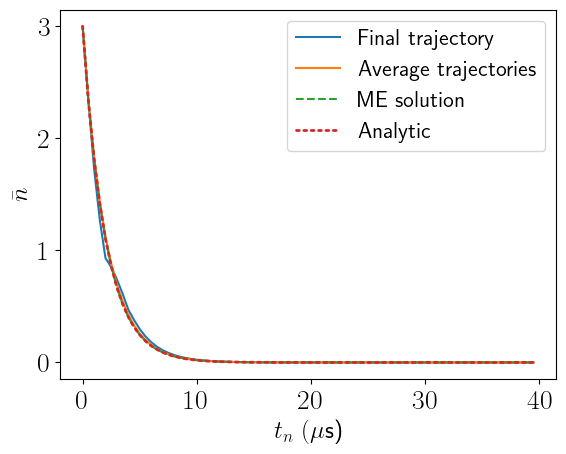

In [15]:
plt.plot(tlist_total, n_cav, label='Final trajectory')
plt.plot(tlist_total, n_cav_avg/Ntrajs, label='Average trajectories')
plt.plot(tlist_total, sol.expect[0], '--',label='ME solution')
plt.plot(tlist_total, n_init*np.exp(-(gamma*delta_t + kappa*dt_total)*nsteps ),linestyle=':', dash_capstyle = 'round', linewidth=2, label='Analytic')
plt.xlabel(r'$t_n\ (\mu$s)')
plt.ylabel(r'$\bar n$')
plt.legend();

Everything matches.